Trees

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import re
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import warnings

In [2]:
os.getcwd()
from thon.Choose import choose_features
# data = choose_features("data/out/features.csv", cv_range = (0, 10), save = False)

In [3]:
# features are automatically trimmed
data = pd.read_csv("data/out/features.csv")
data.columns

Index(['month', 'n', '10yinf_lag12', 'altsales_lag12', 'AN_lag12', 'AN_v_lag3',
       'bf90_lag12', 'bin', 'carcpi_lag12', 'durable_lag12', 'F_lag6',
       'F_v_lag6', 'g_best_new_cars_lag6', 'g_car_lag12',
       'g_car_for_sale_near_me_lag3', 'g_new_cars_lag6', 'g_used_cars_lag6',
       'GM_lag9', 'GM_v_lag9', 'kwhcost_lag6', 'lfrm_lag12', 'lhpi_lag3',
       'localrent_lag3', 'ltrucksa_lag6', 'mfrm_lag12', 'MZDAY_lag6',
       'new_units_lag3', 'new_users_lag9', 'newhouses_lag6', 'ngf1_lag3',
       'ngf2_lag9', 'oil_lag6', 'pageviews_lag12', 'sentiment_lag12',
       'sfrm_lag3', 'shpi_lag3', 'tmaturity_lag12', 'totalsa_lag12',
       'TSLA_lag6', 'TSLA_v_lag9', 'unemployment_lag12', 'XOM_lag6',
       'XOM_v_lag9'],
      dtype='object')

In [4]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, shuffle = False)

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

In [6]:
search = GridSearchCV(pipeline,
                      {'model__max_depth':np.arange(2, 8, 1),
                      'model__ccp_alpha':np.arange(0, 2, 0.1)},                      
                      cv = 5,
                      scoring = 'neg_mean_squared_error',
                      verbose = 1)

In [7]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', DecisionTreeRegressor())]),
             param_grid={'model__ccp_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'model__max_depth': array([2, 3, 4, 5, 6, 7])},
             scoring='neg_mean_squared_error', verbose=1)

In [8]:
search.best_params_

{'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 3}

In [9]:
# Training data

# Train the model
treemodel = DecisionTreeRegressor(max_depth= search.best_params_.get("model__max_depth"), 
                                  ccp_alpha = search.best_params_.get("model__ccp_alpha"),
                                  random_state = 0) 
treemodel.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(treemodel.predict(X_train), index=X_train.index)
test_pred = pd.Series(treemodel.predict(X_test), index=X_test.index)

In [10]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

434.44288758981855


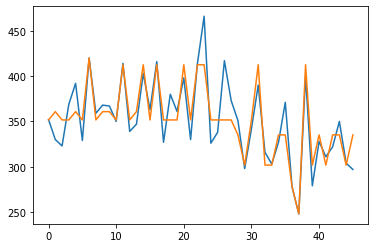

In [11]:
def plot_eval(prediction, actual):
    plt.plot(actual)
    plt.plot(prediction)
    print(mean_squared_error(prediction, actual))
    
plot_eval(train_pred, y_train)

12553.187074829933


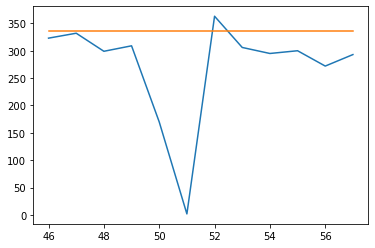

In [12]:
plot_eval(test_pred, y_test)

In [13]:
text_representation = tree.export_text(treemodel, feature_names = list(X_train))
print(text_representation)

|--- g_car_for_sale_near_me_lag3 <= 45.50
|   |--- new_users_lag9 <= 4184.50
|   |   |--- oil_lag6 <= 29.62
|   |   |   |--- value: [420.00]
|   |   |--- oil_lag6 >  29.62
|   |   |   |--- value: [351.65]
|   |--- new_users_lag9 >  4184.50
|   |   |--- F_lag6 <= 12.59
|   |   |   |--- value: [412.50]
|   |   |--- F_lag6 >  12.59
|   |   |   |--- value: [360.80]
|--- g_car_for_sale_near_me_lag3 >  45.50
|   |--- g_car_for_sale_near_me_lag3 <= 48.50
|   |   |--- carcpi_lag12 <= 138.18
|   |   |   |--- value: [248.00]
|   |   |--- carcpi_lag12 >  138.18
|   |   |   |--- value: [278.00]
|   |--- g_car_for_sale_near_me_lag3 >  48.50
|   |   |--- carcpi_lag12 <= 137.82
|   |   |   |--- value: [301.83]
|   |   |--- carcpi_lag12 >  137.82
|   |   |   |--- value: [335.14]



In [14]:
# feature names used in model
def get_tree_importance(model, cols, save = False):
    imp = pd.DataFrame(model.feature_importances_,
                       index = cols,
                       columns = ['importance'])
    if save == True:
        imp.to_csv("data/out/treefeatures.csv")
    else:
        return imp

imp = get_tree_importance(treemodel, X_train.columns)

In [15]:
def save_model(mod, filename):
    with open("models/" + filename, 'wb') as file:
        pickle.dump(mod, file)

save_model(treemodel, "treemodel.pkl")

In [16]:
# Currently naming cols with incorrect lag for model ingestion
def churn(feature_importance_df, complete_dirty_path = "./data/out/complete.csv", ahead = 3):
    
    complete = pd.read_csv(complete_dirty_path)
    idx = feature_importance_df[feature_importance_df["importance"] > 0].index
    
    names = []
    for i in list(idx):
        names.append(i.split("_lag")[0] + "_lag" + str(pd.to_numeric(re.sub(r".*_lag", "", i)) - ahead))
        
    important = complete.filter(names) #### AHHHH BAD
    important.columns = list(idx) #### AHHHHH BAD 
    warnings.warn("Features are named incorrectly, they are led 3 months ahead of their label")
    
    # add unimportant names back with empty values
    dummycols = list(set(feature_importance_df.index).difference(idx))
    dummy = pd.DataFrame(0, index=np.arange(len(important)), columns=dummycols)
    out = pd.concat([important, dummy], axis = 1).tail(ahead)
    
    # reorder cols
    out = out[feature_importance_df.index]
    
    return(out)

newdata = churn(imp)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Features are named incorrectly, they are led 3 months ahead of their label
  del sys.path[0]


In [17]:
newdata

,month,10yinf_lag12,altsales_lag12,AN_lag12,AN_v_lag3,bf90_lag12,bin,carcpi_lag12,durable_lag12,F_lag6,...,sentiment_lag12,sfrm_lag3,shpi_lag3,tmaturity_lag12,totalsa_lag12,TSLA_lag6,TSLA_v_lag9,unemployment_lag12,XOM_lag6,XOM_v_lag9
55,0,0,0,0,0,0,0,139.674,0,5.71,...,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,0,0,139.097,0,6.08,...,0,0,0,0,0,0,0,0,0,0
57,0,0,0,0,0,0,0,137.922,0,6.61,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# predict
treemodel.predict(newdata)

array([335.14285714, 335.14285714, 335.14285714])